# **Sales forecasting of Corporation Favorita Stores using Time Series Regression.**

## **Objective:** 
### To develop a predictive model for store sales for Corporation Favorita, a large grocery retailer headquartered in Ecuador. The model aims to predict the unit sales of numerous items across various Favorita stores, enabling more precise estimation of sales performance.

## Hypotheses for testing:
Hypothesis 1: <br>
```Null```: The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.<br>
```Alternate```: The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

Hypothesis 2: <br>
```Null```: Sales dont increase over time. <br>
```Alternate```: Sales increase with time.

Hypothesis 3: <br>
```Null```: Situating a startup in a particular city does not influence funding.<br>
```Alternate```: Situating a startup in a particular city significantly affects funding.

### Hypothesis 4: <br>
```Null```: Transactions don't have an impact on sales. <br>
```Alternate```: The more the transactions the higher the sales.

## **Research Questions:**

1. How does the presence of promotional activities affect store sales?
2. What is the relationship between oil prices and store sales? 
3. Do holidays and events influence store sales? Are there specific holidays/events that drive higher sales?
4. Do sales on holidays significantly differ from sales on regular days?
5. Is there a significant difference in sales by location and by store type?
6. Which store has the highest average sales, and which one has the lowest?




### **Import packages**

In [3]:
# Data Handling
import pyodbc
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy import stats
from dotenv import dotenv_values


# Statistical Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ttest_ind
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats



# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
from matplotlib.dates import MonthLocator


# Other Packages
import warnings

warnings.filterwarnings("ignore")

## **1. Data Acquistion**

In [4]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("database")
server = environment_variables.get("server")
username = environment_variables.get("user")
password = environment_variables.get("password")


connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"



In [5]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection = pyodbc.connect(connection_string)

In [6]:
# Define SQL queries for each table
query1 = 'SELECT * FROM dbo.oil'
query2 = 'SELECT * FROM dbo.holidays_events'
query3 = 'SELECT * FROM dbo.stores'

# Read data from tables into pandas DataFrames
oil = pd.read_sql(query1, connection)
holidays_events = pd.read_sql(query2, connection)
stores = pd.read_sql(query3, connection)

# Close the database connection
connection.close()

In [7]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


 <div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <h4 style="padding: 15px;
              color:black;">📌 Renaming the type in holiday data to holiday type
    </h4>
  </div>

In [8]:
# Display the first few rows of the DataFrame
holidays_events.head()

# Rename the 'type' column to 'holiday_type'
holidays_events.rename(columns={
    'type': 'holiday_type'
}, inplace=True)

# Print the resulting DataFrame
holidays_events

,date,holiday_type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


Rename type here as holiday type and concat with oil['dailyoilprices']

In [9]:
stores.head()    # View the first 5 rows of the stores dataframe

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
''' sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head() ''' 

" sample_submission = pd.read_csv('data/sample_submission.csv')\nsample_submission.head() "

Do away with this set since sales has no values.

In [11]:
transactions = pd.read_csv('data/transactions.csv')    # load the transactions data
transactions.head()    # View the first 5 rows

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [12]:
train = pd.read_csv('data/train.csv')  # load the transactions data
train.sample(5)   # View the first 5 rows

,id,date,store_nbr,family,sales,onpromotion
1077049,1077049,2014-08-29,29,POULTRY,0.0,0
952689,952689,2014-06-20,4,GROCERY I,3186.0,0
207774,207774,2013-04-27,39,CELEBRATION,0.0,0
955847,955847,2014-06-22,29,BEAUTY,0.0,0
2819468,2819468,2017-05-06,19,HARDWARE,4.0,0


In [13]:
train[(train['sales'] == 770) & (train['store_nbr'] == 25) ]     # Check for rows in train data whose sales is 770 and store number is 25
                                                              # This is to confirm if sales is same as transactions.

,id,date,store_nbr,family,sales,onpromotion
250053,250053,2013-05-21,25,GROCERY I,770.0,0
417552,417552,2013-08-23,25,BEVERAGES,770.0,0
631396,631396,2013-12-21,25,CLEANING,770.0,0


...

In [14]:
# oil.to_csv('data/oil.csv',index=False)
# transactions.to_csv('data/transactions.csv',index=False)
# holidays_events.to_csv('data/holidays_events.csv',index=False)
# stores.to_csv('data/stores.csv',index=False)

## Join Tables

## Join transcations and trains data to form full transactions dataframe

In [15]:
# Merge the 'transactions' DataFrame with the 'train' DataFrame
# This combines the data from both DataFrames based on their common columns, creating a new DataFrame named 'full_transaction'
full_transaction = pd.merge(transactions, train)

# Display a random sample of 5 rows from the 'full_transaction' DataFrame
# The 'sample()' function is used to extract a random subset of rows from the DataFrame for inspectionctions
full_transaction.sample(5)

,date,store_nbr,transactions,id,family,sales,onpromotion
2596147,2017-05-18,44,3778,2841766,BOOKS,0.0,0
1320516,2015-05-04,26,589,1517097,LINGERIE,2.0,0
1290482,2015-04-15,48,2582,1484027,HOME APPLIANCES,0.0,0
1682464,2015-12-04,23,1081,1898350,PERSONAL CARE,122.0,0
2677828,2017-07-03,35,681,2923414,EGGS,192.0,12


## Join the full transactions and stores based on store_number

In [16]:
# Merge the 'full_transaction' DataFrame with the 'sotres' DataFrame
# This combines the data based on the 'sote_nbr' column, using an 'inner' join type
# The result is a new DataFrame named 'result'

result = pd.merge(full_transaction, stores, on='store_nbr', how='inner')
result.head(5)


,date,store_nbr,transactions,id,family,sales,onpromotion,city,state,type,cluster
0,2013-01-01,25,770,561,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1
1,2013-01-01,25,770,562,BABY CARE,0.0,0,Salinas,Santa Elena,D,1
2,2013-01-01,25,770,563,BEAUTY,2.0,0,Salinas,Santa Elena,D,1
3,2013-01-01,25,770,564,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1
4,2013-01-01,25,770,565,BOOKS,0.0,0,Salinas,Santa Elena,D,1


## Join the full transactions and oil data based on date

In [17]:
# Merge the 'result' DataFrame with the 'oil' DataFrame
# This combines the data based on the 'date' column, using an 'inner' join type
# The result is a new DataFrame named 'result1'

result1= pd.merge(result, oil, on='date', how='inner')
result1.sample(5)


,date,store_nbr,transactions,id,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
116915,2013-04-18,54,791,192320,PREPARED FOODS,27.000,0,El Carmen,Manabi,C,3,87.830002
305025,2013-10-08,1,1721,498966,CELEBRATION,0.000,0,Quito,Pichincha,D,13,103.540001
1921173,2016-09-16,54,778,2409111,GROCERY I,2715.000,63,El Carmen,Manabi,C,3,43.040001
894872,2015-03-26,9,1776,1448744,FROZEN FOODS,67.000,0,Quito,Pichincha,B,6,51.410000
547574,2014-05-19,51,1691,896087,BREAD/BAKERY,810.881,0,Guayaquil,Guayas,A,17,102.949997


## Join the full transactions and holidays data based on date

In [18]:
# Merge the 'result1' DataFrame with the 'holidays_events' DataFrame
# This combines the data based on the 'date' column, using an 'inner' join type
# The result is a new DataFrame named 'salesdata'


salesdata= pd.merge(result1, holidays_events, on='date', how='inner')

# Reset the index of the 'salesdata' DataFrame
# The 'drop=True' parameter removes the current index, and 'inplace=True' applies the change directly to the DataFrame
salesdata.reset_index(drop=True,inplace=True)
salesdata.head(5)


,date,store_nbr,transactions,id,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,2013-01-01,25,770,561,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,25,770,562,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,25,770,563,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,25,770,564,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,25,770,565,BOOKS,0.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False


## Drop some columns (id column)

In [19]:
#salesdata.drop(columns='id', inplace=True)

## Rename columns

In [20]:
# Rename store_nbr as store_number amd dcpo;wtocp as oil_prices

salesdata.rename(columns={
    'store_nbr': 'store_number',
    'dcoilwtico': 'oil_prices',
}, inplace=True)
salesdata.sample(5)

,date,store_number,transactions,id,family,sales,onpromotion,city,state,type,cluster,oil_prices,holiday_type,locale,locale_name,description,transferred
52202,2014-04-14,44,4009,833477,PREPARED FOODS,421.543,0,Quito,Pichincha,A,5,104.050003,Holiday,Local,Libertad,Cantonizacion de Libertad,False
269221,2016-12-06,29,1182,2552524,CLEANING,873.000,21,Guayaquil,Guayas,E,10,50.950001,Holiday,Local,Quito,Fundacion de Quito,False
58560,2014-05-12,36,1065,883065,HOME CARE,0.000,0,Libertad,Guayas,E,10,100.889999,Holiday,Local,Puyo,Cantonizacion del Puyo,False
178284,2015-12-22,23,1606,1930410,DELI,168.678,0,Ambato,Tungurahua,D,9,36.119999,Additional,National,Ecuador,Navidad-3,False
209554,2016-04-25,40,1452,2152000,BOOKS,0.000,0,Machala,El Oro,C,3,41.669998,Event,National,Ecuador,Terremoto Manabi+9,False


In [21]:
salesdata.columns  # Get the column names of the salesdata

Index(['date', 'store_number', 'transactions', 'id', 'family', 'sales',
       'onpromotion', 'city', 'state', 'type', 'cluster', 'oil_prices',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred'],
      dtype='object')

In [22]:
salesdata = salesdata[['id','date',  'store_number', 'transactions', 'family', 'sales',
       'onpromotion', 'city', 'state', 'type', 'cluster', 'oil_prices',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred']]   # Rearrange columns of the data

In [23]:
salesdata.head()   # Get first 5 rows

,id,date,store_number,transactions,family,sales,onpromotion,city,state,type,cluster,oil_prices,holiday_type,locale,locale_name,description,transferred
0,561,2013-01-01,25,770,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,562,2013-01-01,25,770,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,563,2013-01-01,25,770,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,564,2013-01-01,25,770,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,565,2013-01-01,25,770,BOOKS,0.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False


## **Generate summary statistics and transpose the rows and columns of the resultant DataFrame then trnsposing for a detailed view.**

In [24]:
# Display descriptive statistics for the 'salesdata' DataFrame
# The 'describe()' function computes various summary statistics for numerical columns
# The 'T' attribute is used to transpose the summary statistics for better readability

salesdata.describe().T

,count,mean,std,min,25%,50%,75%,max
id,322047.0,1.682979e+06,786249.257767,561.000000,1010616.50,1.842406e+06,2.209556e+06,3.000887e+06
store_number,322047.0,2.699467e+01,15.595174,1.000000,13.00,2.700000e+01,4.000000e+01,5.400000e+01
transactions,322047.0,1.734118e+03,1050.335018,54.000000,1030.00,1.409000e+03,2.148000e+03,8.359000e+03
sales,322047.0,4.063835e+02,1246.881240,0.000000,1.00,1.900000e+01,2.412605e+02,1.247170e+05
onpromotion,322047.0,3.727136e+00,15.512095,0.000000,0.00,0.000000e+00,1.000000e+00,7.160000e+02
cluster,322047.0,8.531202e+00,4.713809,1.000000,4.00,9.000000e+00,1.300000e+01,1.700000e+01
oil_prices,300003.0,6.407791e+01,25.147682,27.959999,44.66,5.144000e+01,9.474000e+01,1.079500e+02


## **Checking for duplicate rows.**

In [25]:
# Check for duplicated rows in the 'salesdata' DataFrame
# The 'duplicated()' function returns a boolean Series indicating whether each row is a duplicate
# The 'sum()' function then counts the number of 'True' (duplicated) values in the Series

salesdata.duplicated().sum()

0

 <div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <h4 style="padding: 15px;
              color:black;">📌 There are no duplicate rows!
    </h4>
  </div>

In [26]:
salesdata.to_csv('data/FavoritaStores_Data.csv', index=False)  # Save new data frame as FavoritaStores_Data which is a csv


 <div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <h4 style="padding: 15px;
              color:black;">📌 Data saved to a csv file for further analysis in Power BI.
    </h4>
  </div>

## **2. Using EDA to answer questions.**

### **Both histograms and boxplot are plotted to show distributions and any presence of outliers**

### **Univariate analysis**

>### **2.1. Sales column**



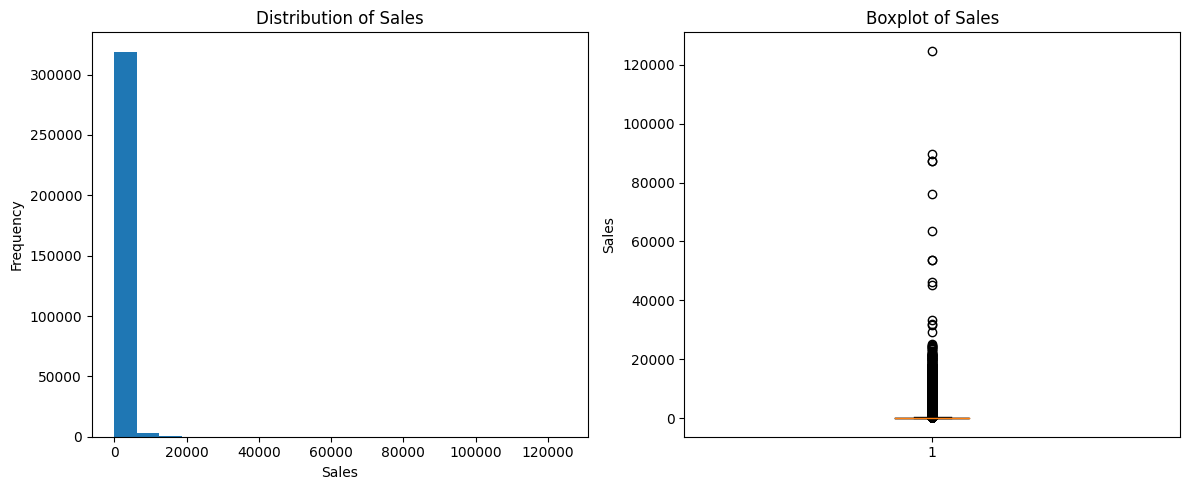

In [27]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(salesdata['sales'], bins=20)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Sales')

# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(salesdata['sales'])
ax2.set_ylabel('Sales')
ax2.set_title('Boxplot of Sales')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
    From our plots:<br><br>
        📌 Sales is positively skewed. <br> <br>
        📌 The median value is thus closer to the first quartile. <br><br>
        📌 The boxplot shows presence of very extreme values. <br><br>        
        📌 There is a high range between the values.
    </h4>
</div>


>### **2.2. Transactions column**



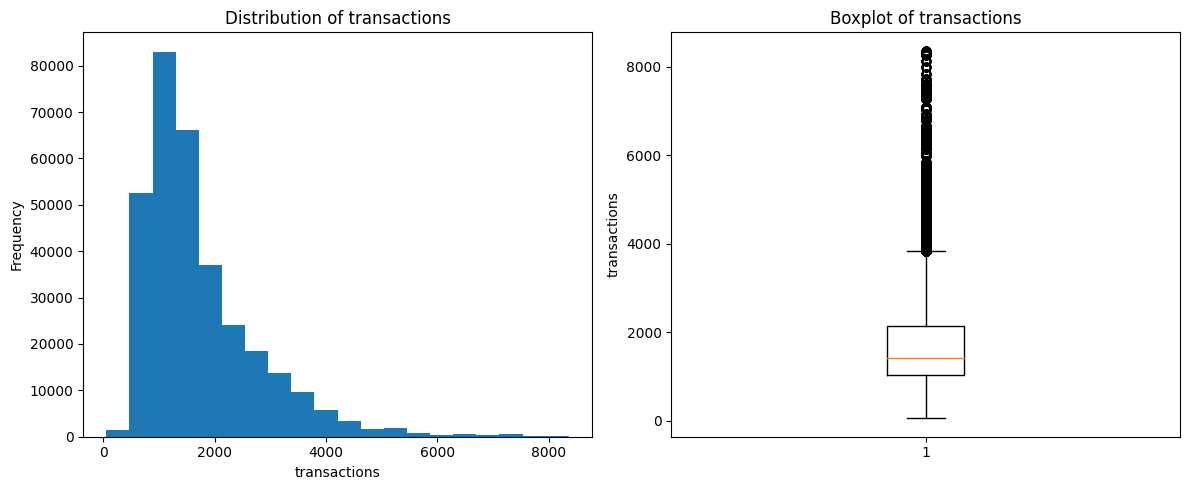

In [28]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(salesdata['transactions'], bins=20)
ax1.set_xlabel('transactions')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of transactions')
plt.grid(False)


# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(salesdata['transactions'])
ax2.set_ylabel('transactions')
ax2.set_title('Boxplot of transactions')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.grid(False)
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
    From the plots:<br>
        📌 The transactions are positively skewed.<br><br>
        📌 Transactions that fall within the interval of 500 - 1500 had the most occurance.<br><br>
        📌 This depicts pressence of outliers as confirmed by the boxplot.
</div>


>### **2.3. Oil Prices column column**



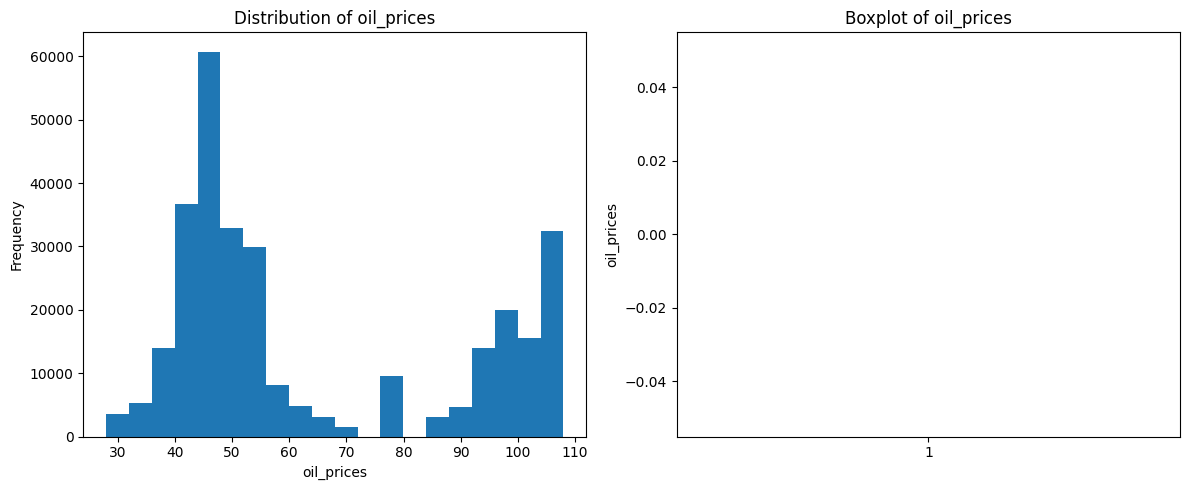

In [29]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(salesdata['oil_prices'], bins=20)
ax1.set_xlabel('oil_prices')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of oil_prices')
plt.grid(False)


# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(salesdata['oil_prices'])
ax2.set_ylabel('oil_prices')
ax2.set_title('Boxplot of oil_prices')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.grid(False)
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 The histogram displays a bimodal distribution characterized by two prominent peaks. <br><br>
        📌 The first peak is observed in the interval between 40 and 55, indicating a concentration of data points in this range. <br><br>
        📌 This suggests that a significant portion of the dataset falls within this range, leading to a higher frequency count within this interval.<br><br>
        📌 The second peak occurs in the interval between 98 and 100. <br><br>
        📌 This peak signifies another concentration of data points in this range, which is distinct from the first peak. <br><br>
        📌 The presence of two distinct peaks suggests the existence of two modes or clusters within the dataset.<br><br>
        📌 Maybe this phenomenon is due to the pressence of some missing data.
        
</div>



>### **2.4. Onpromotion column**



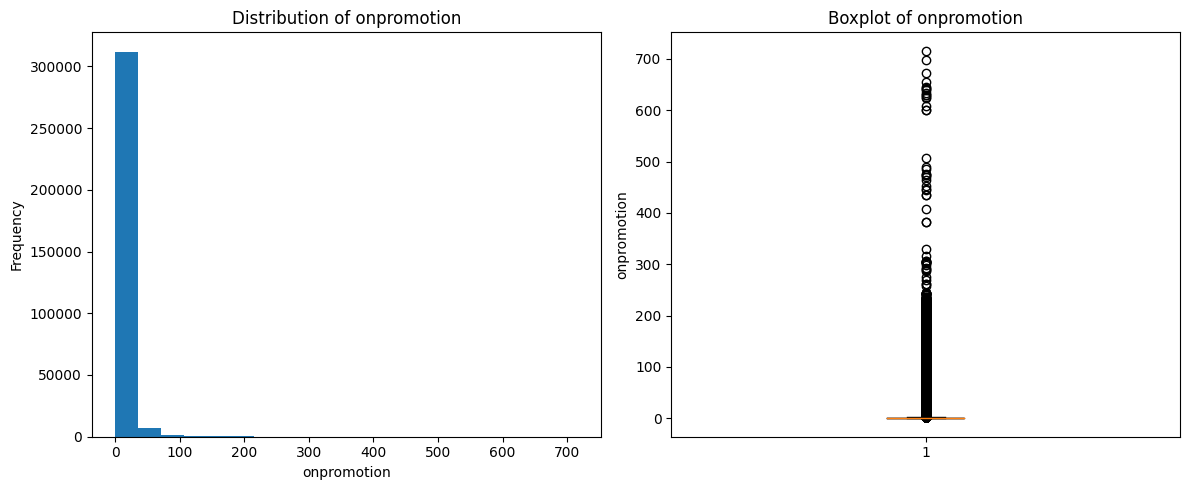

In [30]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(salesdata['onpromotion'], bins=20)
ax1.set_xlabel('onpromotion')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of onpromotion')
plt.grid(False)


# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(salesdata['onpromotion'])
ax2.set_ylabel('onpromotion')
ax2.set_title('Boxplot of onpromotion')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.grid(False)
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
    From our plots:<br><br>
        📌 onpromotion is positively skewed. <br> <br>
        📌 The median value is thus closer to the first quartile. <br><br>
        📌 The boxplot shows presence of very extreme values. <br><br>        
        📌 There is a high range between the values.
    </h4>
</div>

## **3. Bivariate Data Analysis**

>### **3.1. Trend of Daily average sales**



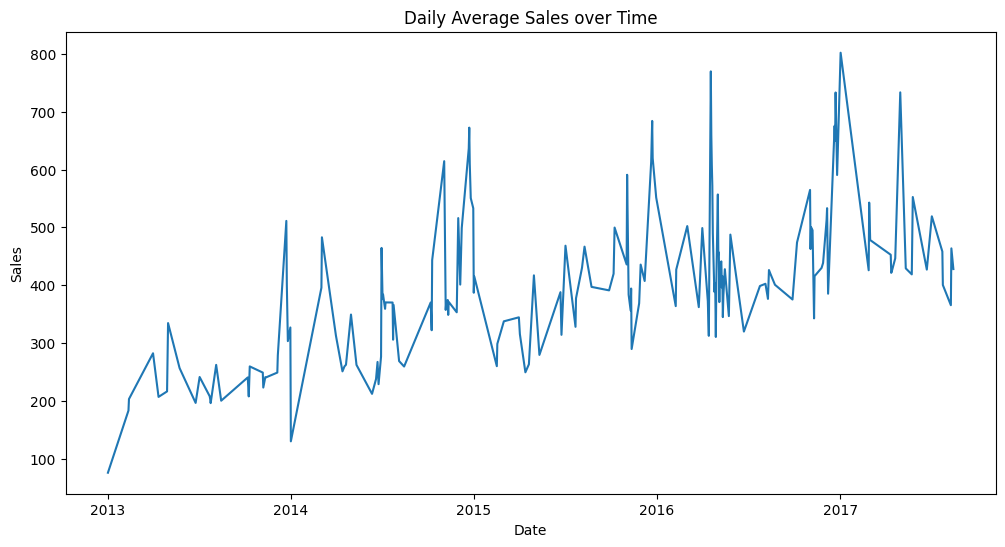

In [31]:
# Converting the 'date' column to datetime format
salesdata['date'] = pd.to_datetime(salesdata['date'])

# Grouping the sales data by date and calculating the mean sales for each day
salesdata_daily = salesdata.groupby('date')['sales'].mean()

# Creating a new figure for the plot with a specified size
plt.figure(figsize=(12, 6))

# Creating a line plot of daily average sales over time
plt.plot(salesdata_daily.index, salesdata_daily.values)

# Adding a label to the x-axis
plt.xlabel('Date')

# Adding a label to the y-axis
plt.ylabel('Sales')

# Adding a title to the plot
plt.title('Daily Average Sales over Time')

# Displaying the plot
plt.show()


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
    From our plot:<br><br>
        📌 Daily average sales exhibit an upward trend over the years, except from 2017. <br> <br>
        📌 There are some seasonal peaks in each year as well, especially at the end of each year. <br><br>        
    </h4>
</div>

>### **3.2. Trend of Daily Average Oil Prices**



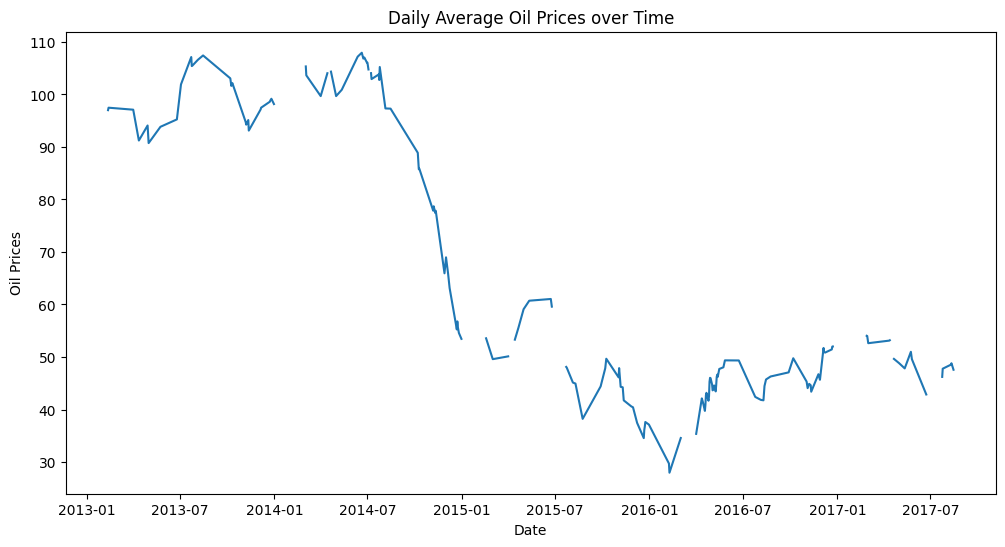

In [32]:
# Converting the 'date' column to datetime format
salesdata['date'] = pd.to_datetime(salesdata['date'])

# Grouping the data by date and calculating the mean oil prices for each day
salesdata_daily = salesdata.groupby('date')['oil_prices'].mean()

# Creating a new figure for the plot with a specified size
plt.figure(figsize=(12, 6))

# Creating a line plot of daily average oil prices over time
plt.plot(salesdata_daily.index, salesdata_daily.values)

# Adding a label to the x-axis
plt.xlabel('Date')

# Adding a label to the y-axis
plt.ylabel('Oil Prices')

# Adding a title to the plot
plt.title('Daily Average Oil Prices over Time')

# Displaying the plot
plt.show()


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
    From our plot:<br><br>
        📌 Trend in Oil Prices: <br>
        The data indicates that there was a notable decrease in oil prices from 2013 to 2015, with the price dropping significantly by more than half. This likely reflects the global decline in oil prices that occurred during this period.<br><br>
        📌 Stability and Recovery: <br>
        The oil prices seem to have stabilized and slightly recovered from 2016 to 2017. While they are still lower than the earlier years, the trend shows a moderate increase.<br><br>
        📌 Economic Factors:<br> 
        These fluctuations in oil prices might be attributed to various economic factors, including changes in supply and demand, geopolitical events, technological advancements in oil extraction, and global economic conditions.<br><br>
        📌 Impact on Various Sectors: <br>
        Fluctuations in oil prices can have significant impacts on various sectors, including energy, transportation, manufacturing, and more. Higher oil prices can lead to increased costs for businesses and consumers, while lower prices might stimulate economic activity.<br><br>
        📌 Year-to-Year Variability: <br>
        The significant variations in mean oil prices from year to year highlight the volatility of the oil market and how sensitive it is to global events and economic conditions.       
    </h4>
</div>

>### **3.3. Sales against holiday type**



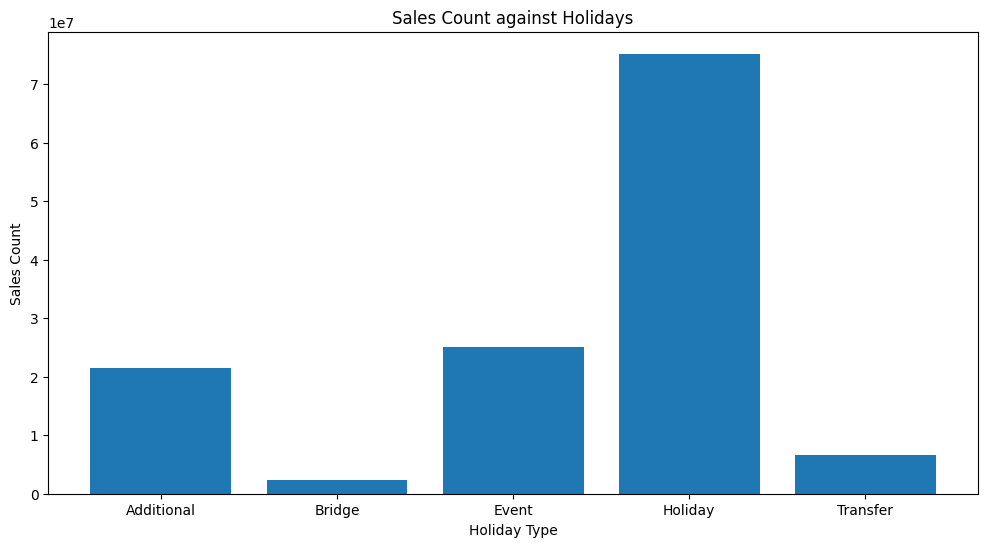

In [33]:
# Converting the 'date' column to datetime format
salesdata['date'] = pd.to_datetime(salesdata['date'])

# Grouping the sales data by holiday type and calculating the sum of sales for each holiday type
salesdata_daily = salesdata.groupby('holiday_type')['sales'].sum()

# Creating a new figure for the plot with a specified size
plt.figure(figsize=(12, 6))

# Creating a bar plot of sales count against holiday types
plt.bar(salesdata_daily.index, salesdata_daily.values)

# Adding a label to the x-axis
plt.xlabel('Holiday Type')

# Adding a label to the y-axis
plt.ylabel('Sales Count')

# Adding a title to the plot
plt.title('Sales Count against Holidays')

# Displaying the plot
plt.show()


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
    From our plot:<br><br>
        📌 Sales Distribution: <br>
        The data indicates how sales are distributed across different holiday types. Some holiday types, like 'Holiday' and 'Event,' have significantly higher sales counts compared to others.<br><br>
        📌 Impact of Holidays: <br>
        It's evident that holidays, whether they are 'Additional,' 'Event,' or traditional 'Holiday' types, contribute significantly to sales. 'Event' and 'Holiday' holidays, in particular, seem to have a substantial impact on sales.<br><br>
        📌 Variation in Sales:<br> 
        The variation in sales counts across different holiday types suggests that some holidays are more commercially impactful than others. This could be due to various factors, such as increased consumer spending during certain holiday periods or specific sales promotions associated with particular holiday types.<br><br>
        📌 Seasonal Trends: <br>
        Understanding how different holiday types contribute to sales can also reveal seasonal trends and patterns in consumer behavior. These insights can guide inventory management and staffing decisions.<br><br>               
    </h4>
</div>

>### **3.3. Sales against store number**



Text(0.5, 1.0, 'Top 10 Sales Count against Store Number')

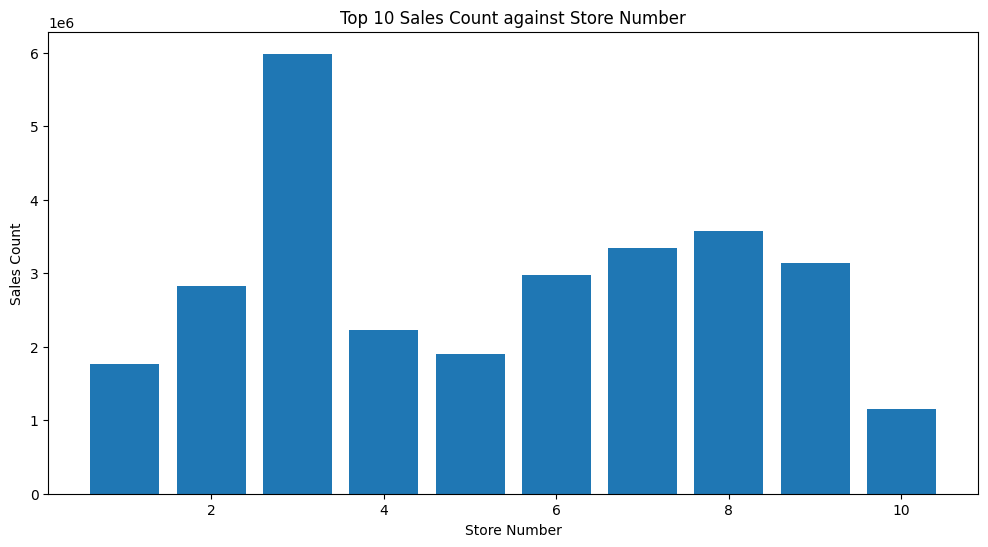

In [34]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('store_number')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (12,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Store Number')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against Store Number')


Text(0.5, 1.0, 'Bottom 10 Sales Count against Store Number')

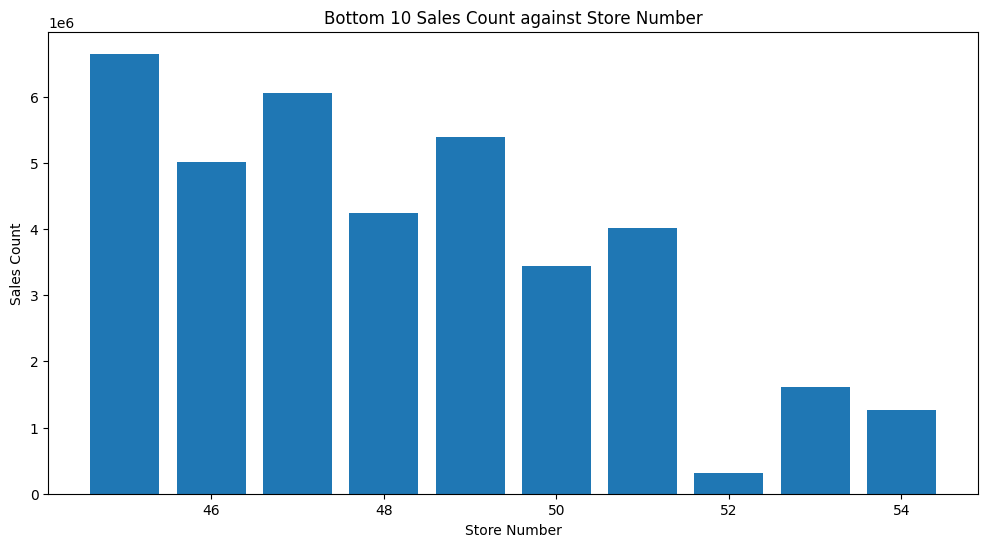

In [35]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('store_number')['sales'].sum().tail(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (12,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Store Number')
plt.ylabel('Sales Count')
plt.title('Bottom 10 Sales Count against Store Number')


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 After displaying both the top 10 and bottom 10 most store salers the highest store seller was store number 3 and the bottom store seller being store number 52.
</div>


> ### **3.4 Sales against Product**

Text(0.5, 1.0, 'Top 10 Sales Count against Product Sold')

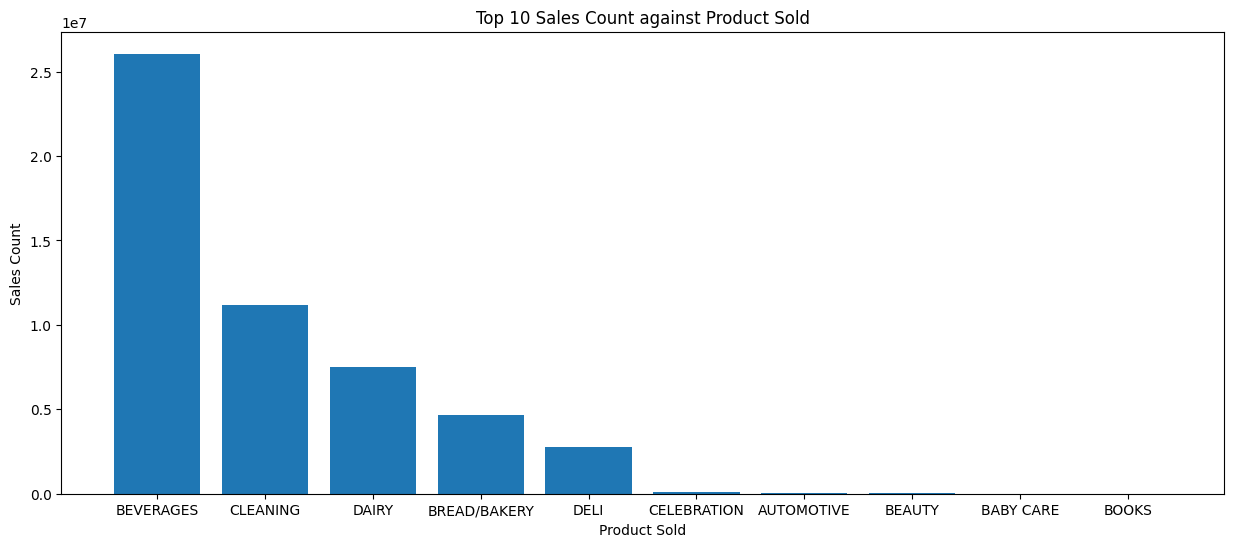

In [36]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('family')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Product Sold')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against Product Sold')


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 After displaying the top 10 product with most sales beverages were the leading products followed by cleaning products
</div>


> ### **3.5 Sales against State**

Text(0.5, 1.0, 'Top 10 Sales Count against State')

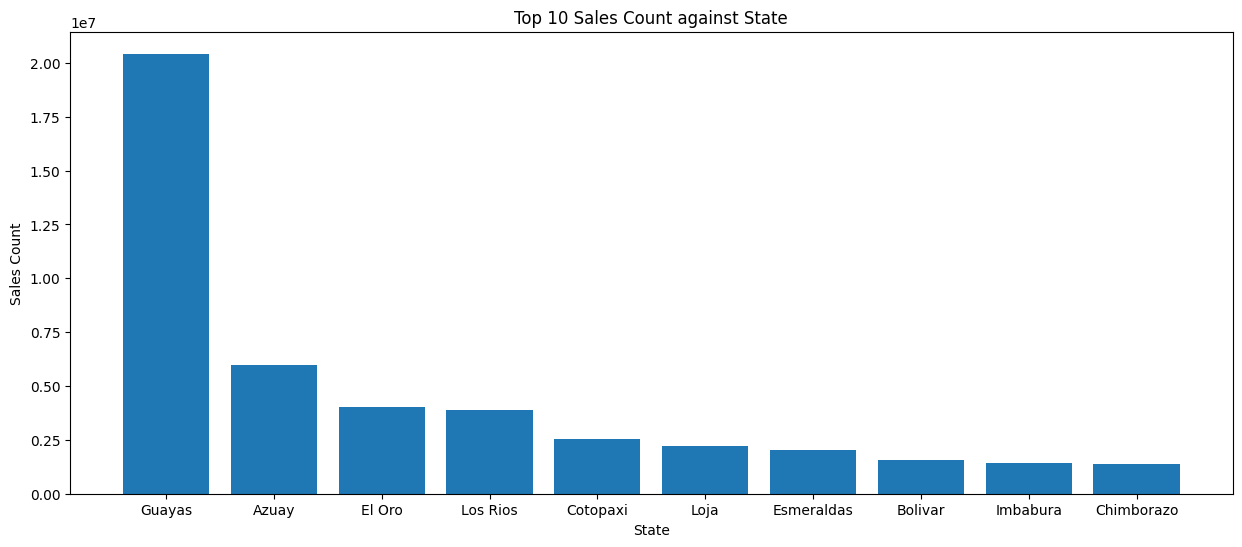

In [37]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('state')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('State')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against State')


Text(0.5, 1.0, 'Sales Count in Various series in Guayas')

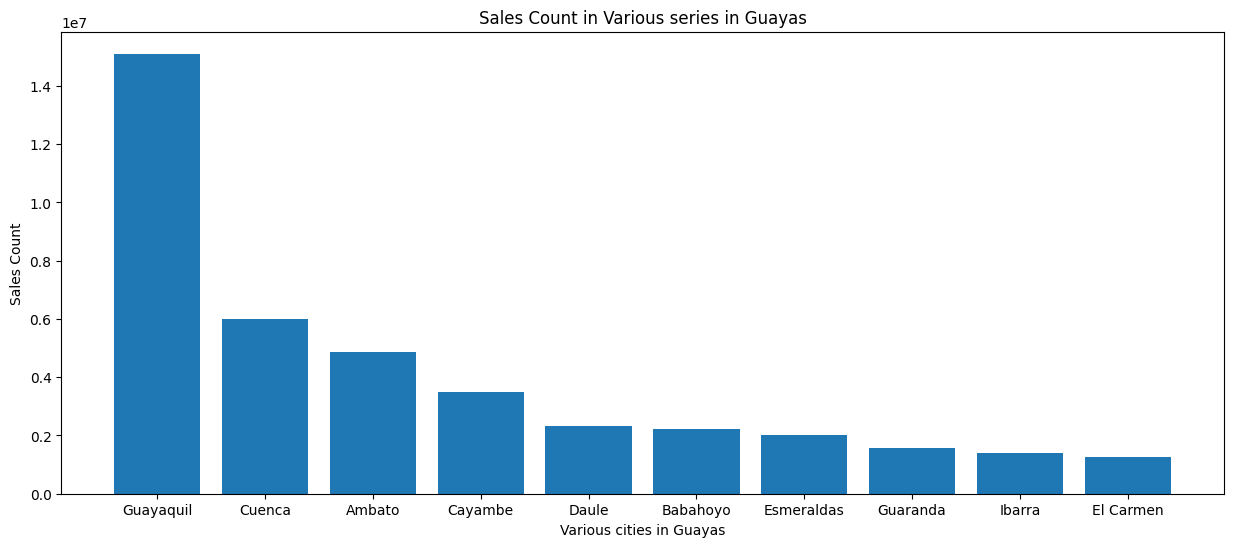

In [38]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata[salesdata['state']=='Guayas']
salesdata_daily=salesdata.groupby('city')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Various cities in Guayas')
plt.ylabel('Sales Count')
plt.title('Sales Count in Various series in Guayas')



<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 Most sales where recorded in the state of Guayas. Given the state of Guayas the highest city with most sales in Guayas is Guayaquil
</div>


> ### **3.6. Sales against type**

Text(0.5, 1.0, 'Top 10 Sales Count against State')

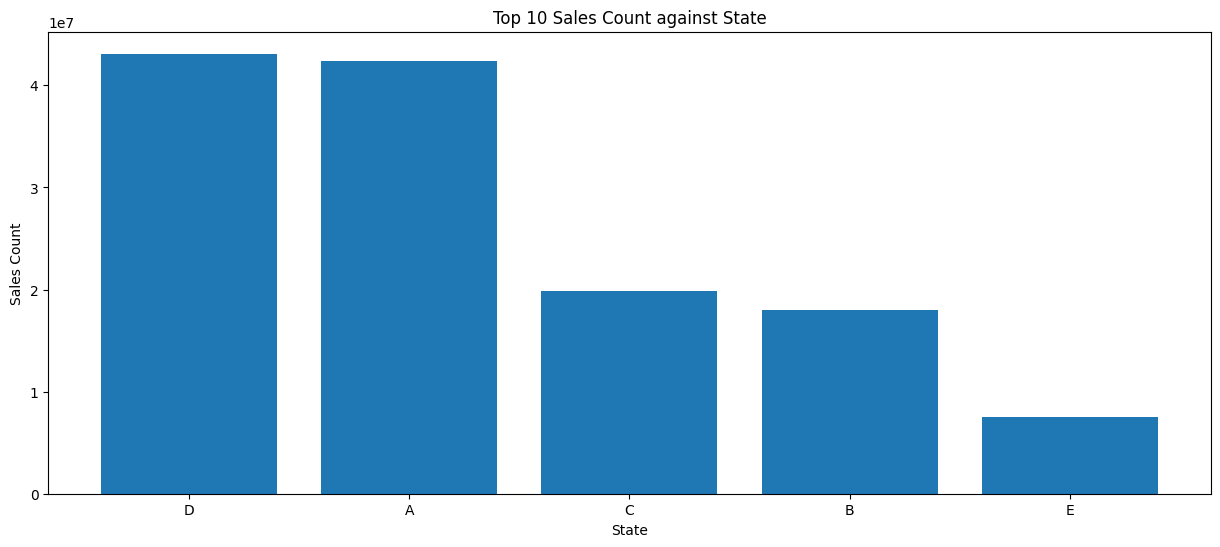

In [39]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('type')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('State')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against State')


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 Most sales where related to product of type D and the least of product type E
</div>


## **4. Time Series Analysis of sales by resampling**

### We visualize the time series of sales across time

In [40]:
# Choose date and sales columns
timeseriesdata=salesdata[['sales','date']]
timeseriesdata.index = timeseriesdata['date']
timeseriesdata
# make date the index
del timeseriesdata['date']
timeseriesdata



,sales
date,
2013-01-01,0.00000
2013-01-01,0.00000
2013-01-01,2.00000
2013-01-01,810.00000
2013-01-01,0.00000
...,...
2016-10-07,253.38101
2016-10-07,43.00000
2016-10-07,281.20200


>### **4.1. Yearly Series of Total Sales**

Text(0, 0.5, 'Sales')

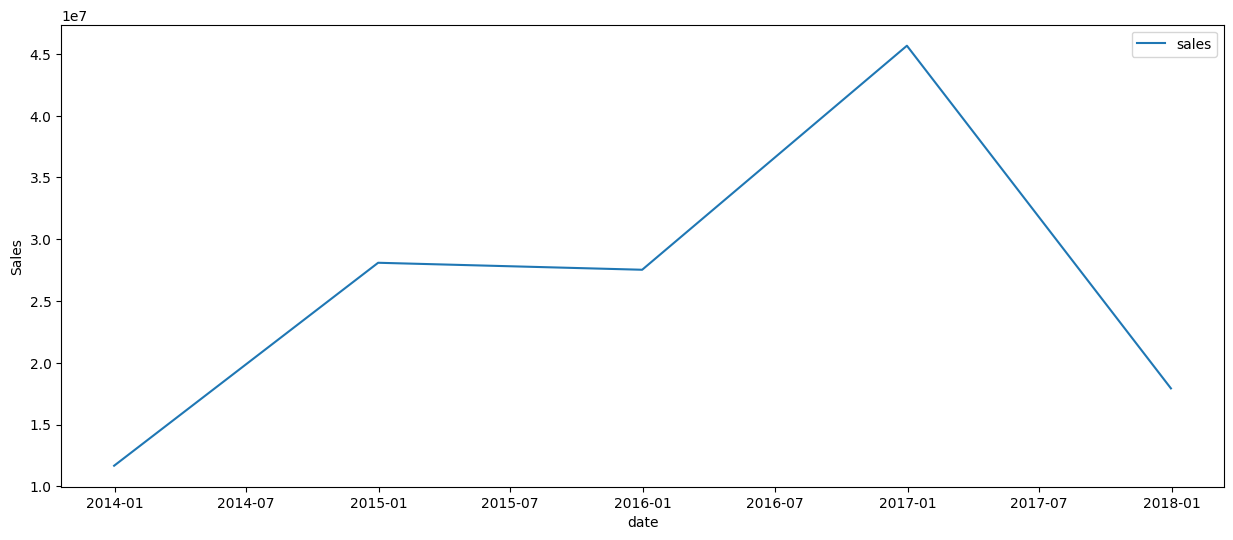

In [41]:
sales_per_year= timeseriesdata.resample('Y').sum()
plt.figure(figsize= (15,6))
sns.lineplot(sales_per_year)
plt.ylabel('Sales')


>### **4.2. Analyzing monthly sales across each year**

In [42]:
timeseriesdata= timeseriesdata.resample('M').sum()



>## **4.2.1. Year 2013**

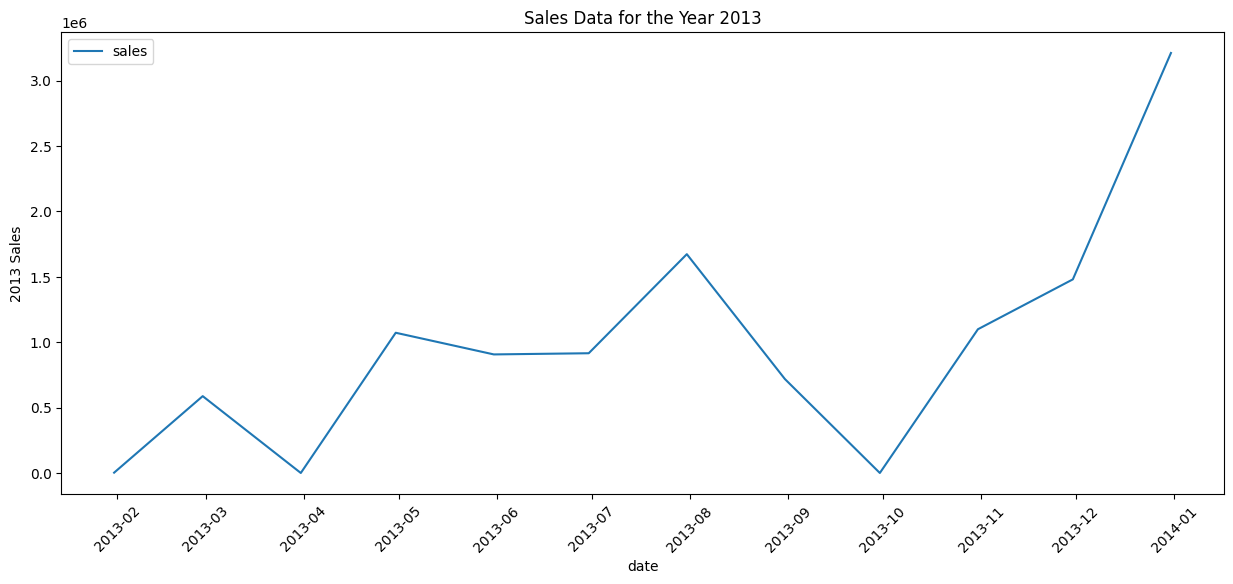

In [43]:
data2013 = timeseriesdata[timeseriesdata.index.year == 2013]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2013)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2013 Sales')
plt.title('Sales Data for the Year 2013')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>## **4.2.2. Year 2014**

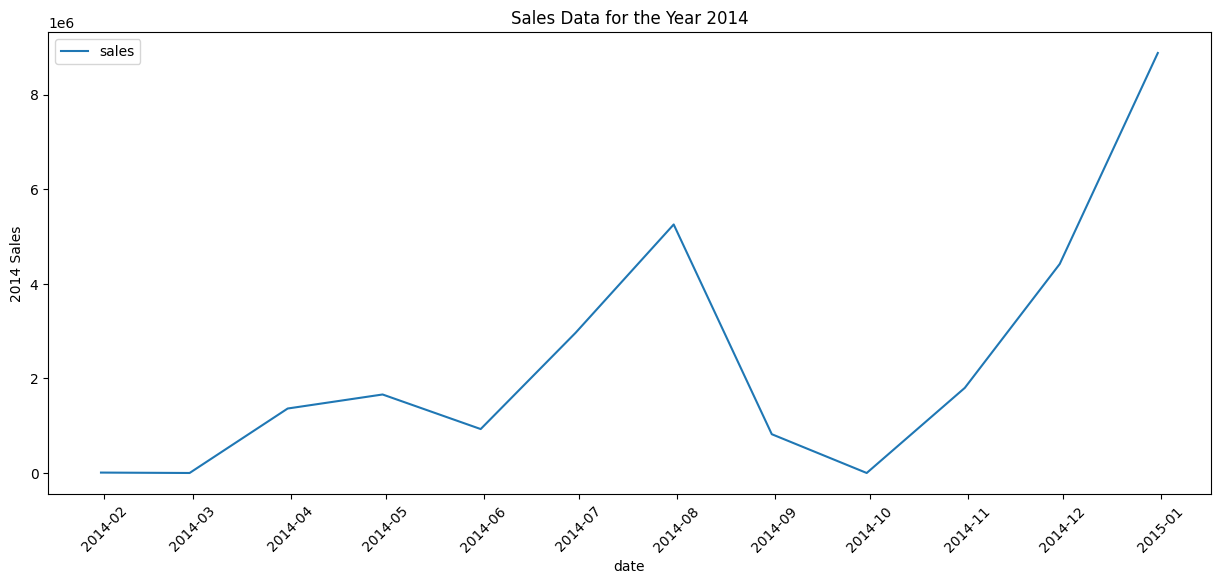

In [44]:
data2014 = timeseriesdata[timeseriesdata.index.year == 2014]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2014)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2014 Sales')
plt.title('Sales Data for the Year 2014')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>## **4.2.3. Year 2015**

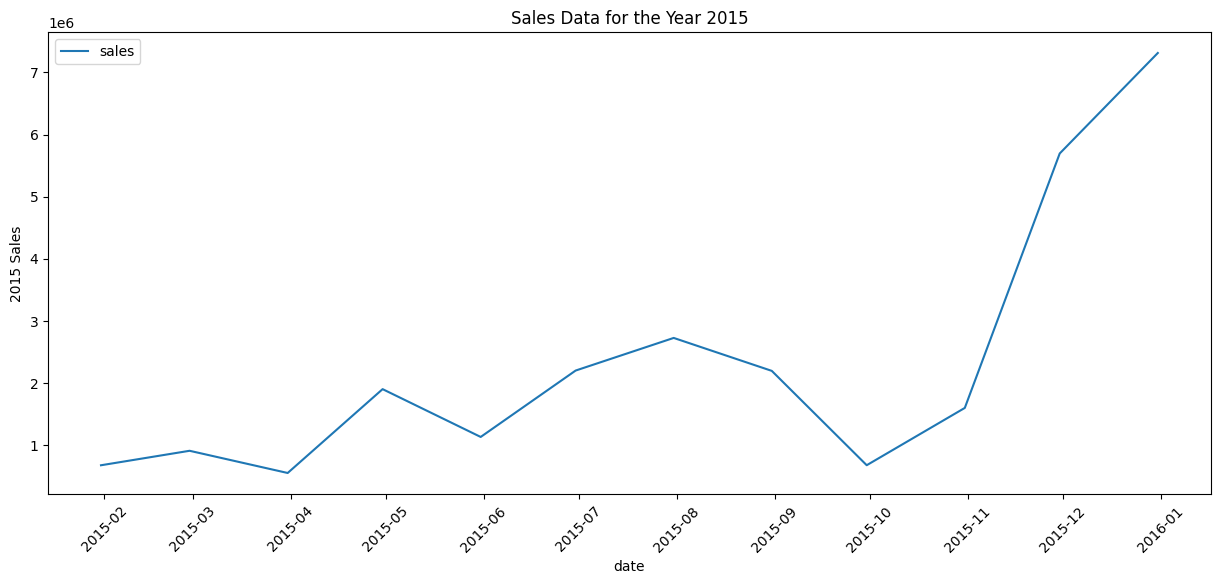

In [45]:
data2015 = timeseriesdata[timeseriesdata.index.year == 2015]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2015)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2015 Sales')
plt.title('Sales Data for the Year 2015')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>## **4.2.4. Year 2016**

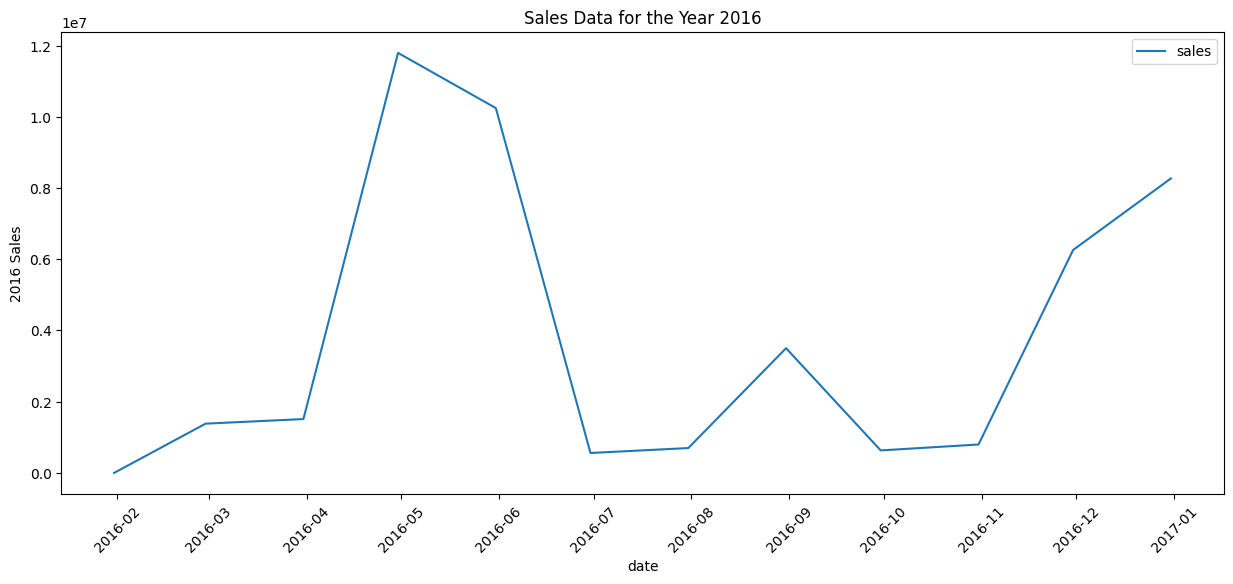

In [46]:
data2016 = timeseriesdata[timeseriesdata.index.year == 2016]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2016)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2016 Sales')
plt.title('Sales Data for the Year 2016')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>## **4.2.5. Year 2013**

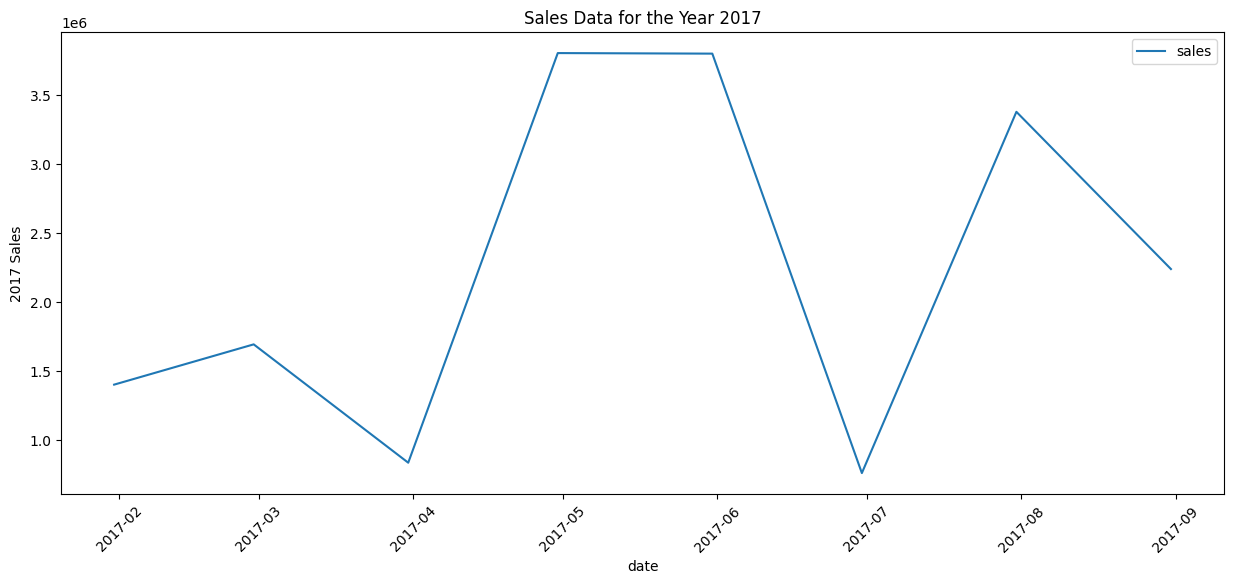

In [47]:
data2017 = timeseriesdata[timeseriesdata.index.year == 2017]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2017)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2017 Sales')
plt.title('Sales Data for the Year 2017')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



## **4.3. Sales series across months**

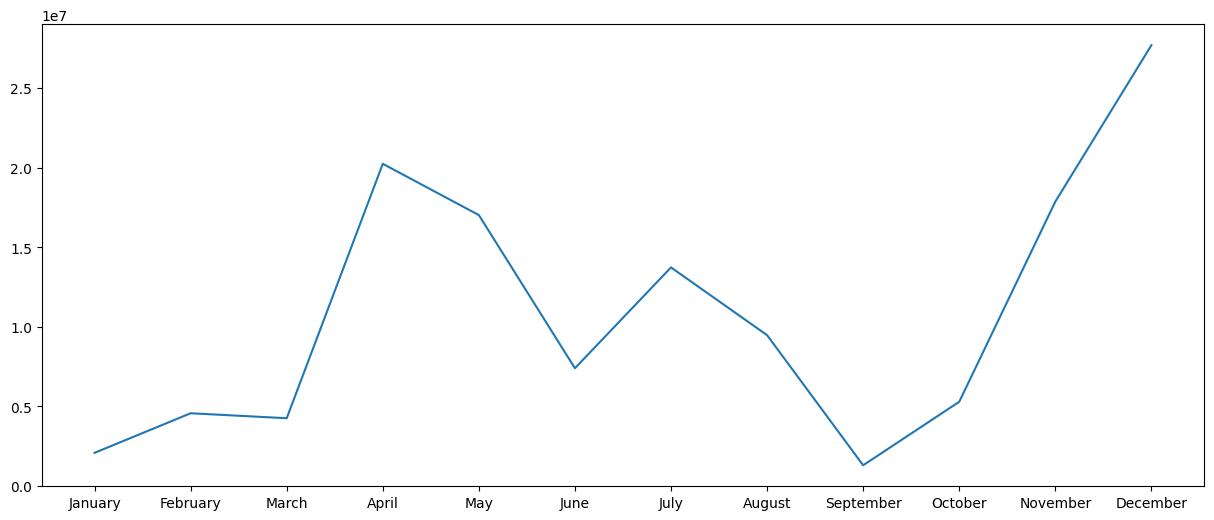

In [48]:

# Group by month and calculate the sum of sales
monthly_sales = salesdata.groupby(salesdata['date'].dt.strftime('%B'))['sales'].sum()
# List of month names in order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Convert month names to categorical with specified order
monthly_sales.index = pd.Categorical(monthly_sales.index, categories=month_order, ordered=True)
# Sort the index to order the months
monthly_sales = monthly_sales.sort_index()
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
plt.plot(monthly_sales)
plt.show()





<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        The sales start increasing from september but exponentionally increase from October to December and from March to April. The highest purchases where witnessed in December and the lowest in September.
    </h4>
</div>


## **4.4. Sales Series in Date**

In [49]:
salesdata['date']=pd.to_datetime(salesdata['date'])
daily_sales = salesdata.groupby(salesdata['date'].dt.day)['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        The highest sales are recorded at the beginning and at the end of the month.
    </h4>
</div>


## **Sales Series Quarterly**

Text(0, 0.5, 'Sales')

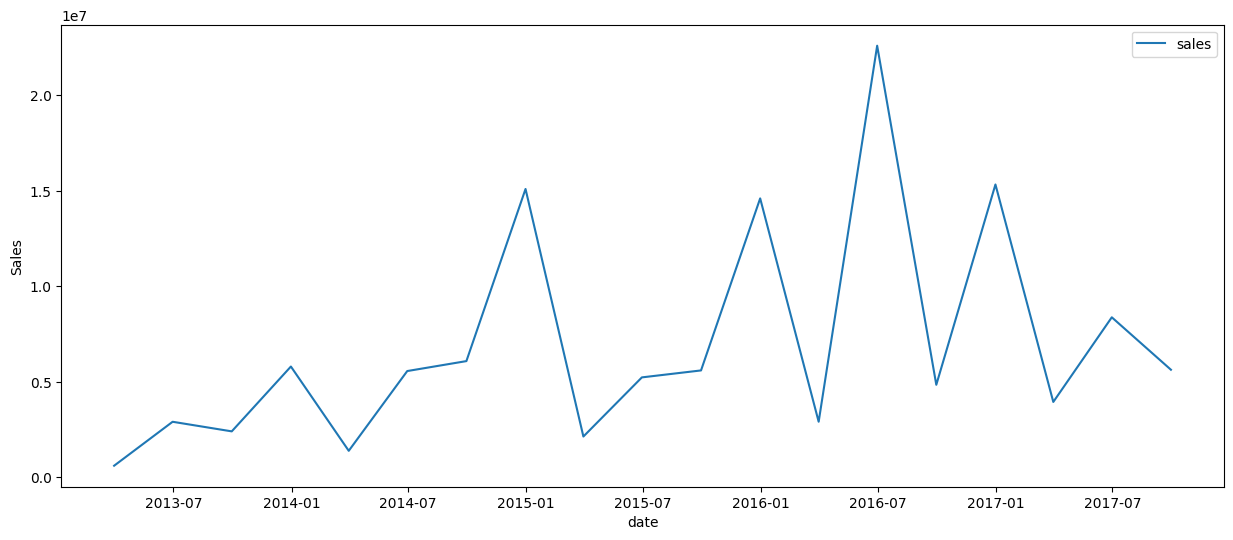

In [50]:
sales_per_quarter=timeseriesdata.resample('Q').sum()
plt.figure(figsize= (15,6))
sns.lineplot(sales_per_quarter)
plt.ylabel('Sales')


>## **MultiVariate Analysis**

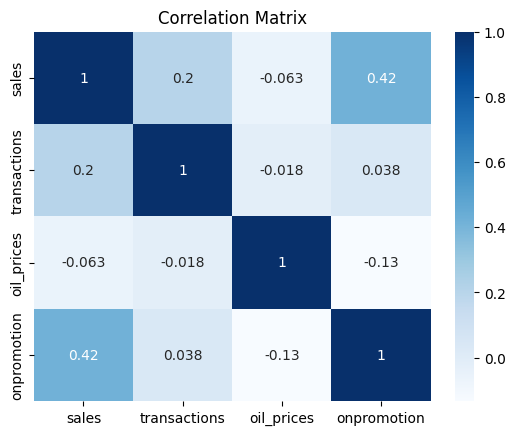

In [51]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'oil_prices','onpromotion']

# Compute correlation matrix
corr_matrix = salesdata[numerical_vars].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        There is a significant relationship between number of items on promotion with slaes as well as a week relation with transactions and sales.
    </h4>
</div>


## **5. Testing Hypothesis**

### Before hypothesis testing we explore the distribution of sales.Using shapiro wilk test to explore distribution.

In [52]:
# Group the data by 'Year Funded'
grouped_data = salesdata.groupby('date')['sales'].sum()
grouped_data
# Perform Shapiro-Wilk test for each group
statistic, p_value = stats.shapiro(grouped_data)
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic)
print("P-value:", p_value)
if p_value < 0.05:
    print("The data does not follow a normal distribution.")
else:
    print("The data follows a normal distribution.")

Shapiro-Wilk Test Results:
Statistic: 0.8635020852088928
P-value: 1.2377075926661707e-11
The data does not follow a normal distribution.


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        The sales do not follow normal distribution.
    </h4>
</div>


### **The distribution is not normal hence non parametric ANOVA is used.**


### **Hypothesis 1: <br>**
#### ```Null```: The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.<br>
#### ```Alternate```: The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

>### On promotion .

In [53]:
 
#for this example we will use the Pearson Correlation.
alpha = 0.05
pearson_coef, p_value = stats.pearsonr(salesdata["sales"], salesdata["onpromotion"])
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", round(p_value,3) )
if p_value < alpha:
    print("Reject the null hypothesis. The promotional activities have a significant impact on store sales for Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis. The promotional activities dont have a significant impact on store sales for Corporation Favorita..")

Pearson Correlation Coefficient:  0.4180289197242539 and a P-value of: 0.0
Reject the null hypothesis. The promotional activities have a significant impact on store sales for Corporation Favorita.


>### Holiday Type .

In [54]:
def perform_anova(data_frame, column_name, value_column):
    groups = data_frame[column_name].unique()
    group_data = [data_frame.query(f'{column_name}=="{group}"')[value_column] for group in groups]
    fvalue, pvalue = stats.f_oneway(*group_data)
    return pvalue

# Assuming salesdata is your DataFrame containing the "sales" and "holiday_type" columns
p_value = perform_anova(salesdata, 'holiday_type', 'sales')

print("p_value:", round(p_value, 3))
if p_value < alpha:
    print("Reject the null hypothesis. The holidya_types have a significant impact on store sales for Corporation Favorita.")
else:
    print("Fail to reject the null hypothesis. The holiday_types dont have a significant impact on store sales for Corporation Favorita..")


p_value: 0.0
Reject the null hypothesis. The holidya_types have a significant impact on store sales for Corporation Favorita.


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        Conclusion : The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.
    </h4>
</div>


### **Hypothesis 2: <br>**
### ```Null```: Sales do not increase over time. <br>
### ```Alternate```: Sales increase with time.



In [55]:
## print each amount in each stage as a list and get the amount per stage as an array

amounts_per_year=salesdata.groupby("date")['sales'].apply(list)
amount_year = np.array(amounts_per_year)

# Perform one-way ANOVA
test_statistic, p_value = stats.kruskal(*amount_year)
print(f"P_value: {p_value}")


# Interpret the results
if p_value < alpha:
    print("Reject the null hypothesis concluding that sales increase with time.")
else:
    print("Fail to reject the null hypothesis concluding that sales dont increase with time.")


P_value: 0.0
Reject the null hypothesis concluding that sales increase with time.


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        Conclusion : The sales increase over time for Corporation Favorita.
    </h4>
</div>


### **Hypothesis 3: <br>**
### ```Null```: Situating a startup in a particular city does not influence sales.<br>
### ```Alternate```: Situating a startup in a particular city significantly affects sales.



In [56]:
def perform_anova(data_frame, column_name, value_column):
    groups = data_frame[column_name].unique()
    group_data = [data_frame.query(f'{column_name}=="{group}"')[value_column] for group in groups]
    fvalue, pvalue = stats.f_oneway(*group_data)
    return pvalue

# Assuming salesdata is your DataFrame containing the "sales" and "holiday_type" columns
p_value = perform_anova(salesdata, 'city', 'sales')

print("p_value:", round(p_value, 3))
if p_value < alpha:
    print("Reject the null hypothesis. Situating a startup in a particular city significantly affects sales.")
else:
    print("Fail to reject the null hypothesis. Situating a startup in a particular city does not influence sales")


p_value: 0.0
Reject the null hypothesis. Situating a startup in a particular city significantly affects sales.


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        Conclusion : Situating a startup in a particular city significantly affects sales.
else:
    </h4>
</div>


### **Hypothesis 4: <br>**
### ```Null```: Transactions don't have an impact on sales. <br>
### ```Alternate```: Transactions have an impact on sales

In [57]:
 
#for this example we will use the Pearson Correlation.
pearson_coef, p_value = stats.pearsonr(salesdata["sales"], salesdata["transactions"])
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", round(p_value,3) )
if pearson_coef < alpha:
    print("Reject the null hypothesis. Transactions have an impact on sales.")
else:
    print("Fail to reject the null hypothesis. Transactions dont have an impact on sales.")

Pearson Correlation Coefficient:  0.20369083856199666 and a P-value of: 0.0
Fail to reject the null hypothesis. Transactions dont have an impact on sales.


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        The transactions have an impact on sales
    </h4>
</div>


## **6. Stationarity Test**

 ### A stationary time series is a series whose statistical properties are independent of the point in time at which they are observed. A stationary time series has a constant variance and it always returns to the long-run mean

## **Ways to check stationarity**
### i. Visualisation using trends, irregularity and seasonality.

### ii. Statistical tests using unit root stationary tests. Unit root test determines how strongly a time series is defined by a trend using tests like:
#### Augmented Dickey Fuller test (ADH Test)
#### Kwiatkowski-Phillips-Schmidt-Shin — KPSS test (trend stationary)
#### Philips Perron test (PP Test)


> ### **6.1 Augumented Duckey Fuller Test(ADH Test)**

In [60]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(salesdata['sales'])  

# Print the test result
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpret the results
if result[1] <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")


ADF Statistic: -34.42792849980977
p-value: 0.0
Critical Values: {'1%': -3.4303703113224735, '5%': -2.861548977354518, '10%': -2.566774778319785}
The time series is likely stationary.


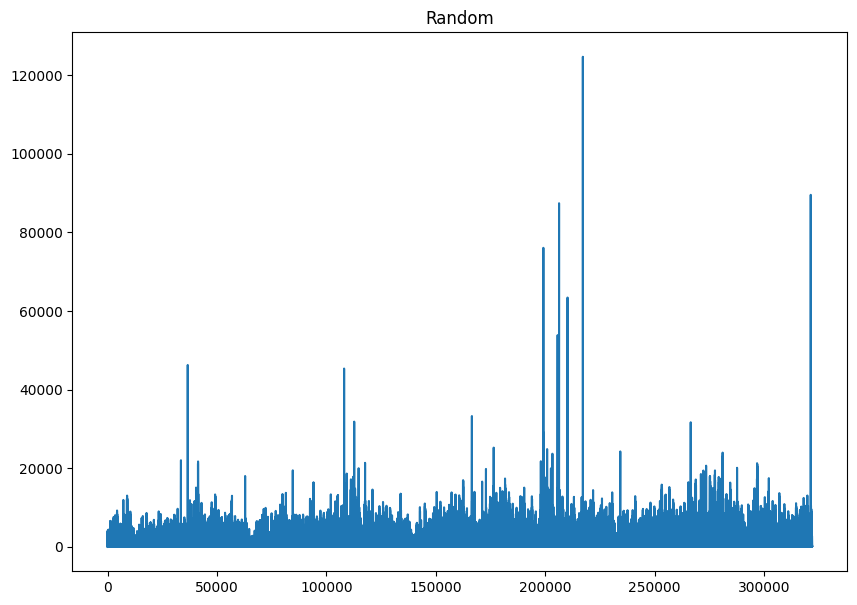

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(figsize=(10,7))
plt.plot(salesdata['sales']);
plt.title('Random');